# Projet DS 

[ETAPE 1](#etap1)
1. [Description du jeu de données](#part1)
    - [Description des variables](#part1sec1)
    - [Description de la cible](#part1sec2)
    - [Valeurs manquantes](#part1sec3)
1. [Tableaux profils colonnes](#part2)
1. [Analyses variables qualitatives](#part3)
1. [Feature engineering](#part4)
1. [Bilan audit et création dummies](#part5)

[ETAPE 2](#etap2)

# ETAPE 1

In [542]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from scipy import stats
%matplotlib inline
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
from scikitplot.metrics import plot_cumulative_gain

In [543]:
raw_data = pd.read_csv('octroi_RCI.csv', sep = ';', decimal= ',', header=0, parse_dates=['mois_gestion'], dtype = {'STITUATION_FAM':'category', 'MODE_LOGT':'category', 'VN_VO':'category', 'MARQUE':'category', 'anciennete_rci':'category', 'def12_31': 'category'})
df = raw_data.copy()
df = df.drop('mois_gestion', axis=1)
raw_data.head() #(8457, 19)

,ANC_EMPLOI,STITUATION_FAM,MODE_LOGT,AGE_VEH,VN_VO,MARQUE,PRIX_VEH,MT_APPORT,MT_FINANCE,MT_MENS,VR_BALLON,DUREE_CONTRAT,MT_PREST,MT_ASSUR,mois_gestion,age_cli,anciennete_rci,pc_appo,def12_31
0,65,2,1,NaN,VN,REN,19584.65,0.0,19584.65,95.01,19584.63,6,NaN,NaN,2015-01-03,28,1,0,0
1,563,11,2,28.0,VO,REN,16995.00,2123.0,14872.00,312.34,NaN,60,150.0,NaN,2014-01-06,64,3,12,0
2,107,2,2,16.0,VO,REN,19950.00,3869.0,16081.00,329.93,NaN,60,150.0,NaN,2015-01-08,51,3,19,0
3,143,2,2,10.0,VO,REN,17500.00,7143.5,10356.50,217.51,NaN,60,150.0,NaN,2015-01-04,42,4,41,0
4,110,2,NaN,7.0,VO,REN,19740.00,3789.4,15950.60,310.33,7523.04,36,150.0,395.0,2015-01-02,34,4,19,0


In [544]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8457 entries, 0 to 8456
Data columns (total 19 columns):
ANC_EMPLOI        8457 non-null int64
STITUATION_FAM    8457 non-null category
MODE_LOGT         8349 non-null category
AGE_VEH           2454 non-null float64
VN_VO             8457 non-null category
MARQUE            8457 non-null category
PRIX_VEH          8457 non-null float64
MT_APPORT         8457 non-null float64
MT_FINANCE        8457 non-null float64
MT_MENS           8457 non-null float64
VR_BALLON         3219 non-null float64
DUREE_CONTRAT     8457 non-null int64
MT_PREST          7177 non-null float64
MT_ASSUR          1702 non-null float64
mois_gestion      8457 non-null datetime64[ns]
age_cli           8457 non-null int64
anciennete_rci    1186 non-null category
pc_appo           8457 non-null int64
def12_31          8457 non-null category
dtypes: category(6), datetime64[ns](1), float64(8), int64(4)
memory usage: 910.7 KB


## Description du jeu de données <a id="part1"></a>

### Description des variables <a id="part1sec1"></a>

On dispose de 19 variables :
VARIABLE / SEGMENT / TYPE / EXPECTATION

**VARIABLE CIBLE**
- **def12_31**: indique si la personne a fait défaut 1=Oui / 0=Non. var. quali. 2mod

**FEATURES**

Client
- **age_cli**: Age du client. N
- **ANC_EMPLOI** : Ancienneté à l'emploi. N
- **STITUATION_FAM** : Situation familiale. C (6 mods) (1=Marié, 2=Célib, 3=Divorcé, 4=Veuf, 5=Séparé, 11=Colloc)
- **MODE_LOGT** : Mode de logement C (4 mods) (1=locataire, 2=proprio, 3=autre, 4=chez les parents)
- **anciennete_rci**: Ancienneté relation rci. C (4 mods)
- **mois_gestion**: Mois d'entrée en gestion. C

Contrat
- **pc_appo**: Pourcentage d'apport. N
- **MT_APPORT** : Montant de l'apport. N
- **MT_FINANCE** : Montant financé. N
- **MT_MENS**: Montant de la mensualité. N
- **VR_BALLON**: Montant ballon. N
- **DUREE_CONTRAT**: Durée du contrat. N
- **MT_PREST**:	Montant des prestations. N
- **MT_ASSUR**:	Montant des assurances. N

Véhicule
- **PRIX_VEH** : Prix du véhicule. N
- **AGE_VEH** : Age du véhicule. N
- **MARQUE** : Marque. C
- **VN_VO** : Type de véhicule. C (2 mods : VN=véhicule neuf /VO= véhicule occasion)

On s'attend à ce que les variables age du client, ancienneté à l'emploi, pourcentage d'apport / montant apport, durée du contrat et prix du véhicule soient les vars. les plus importantes.

### Etude de la cible <a id="part1sec2"></a>




In [545]:
tab_tmp = pd.crosstab(index = raw_data['def12_31'], columns ='count')
round(tab_tmp/tab_tmp.sum(),3)
pd.concat([tab_tmp,round(tab_tmp/tab_tmp.sum()*100,0)], axis =1, keys= ['Effectif', 'Pourcentage'])

,Effectif,Pourcentage
col_0,count,count
def12_31,,
0,8359,99.0
1,98,1.0


On observe que notre jeu de données est particulièrement déséquilibré. Environ 1% de gens ayant fait défaut.

### Valeurs manquantes <a id="part1sec3"></a>

A quel point les valeurs sont manquantes ? 
Est-ce dû au hasard ou est-ce qu'il y a un pattern ? 


In [546]:
total = raw_data.isnull().sum().sort_values(ascending=False)
percentage = (round(raw_data.isnull().sum()/raw_data.isnull().count(), 3)*100).sort_values(ascending = False)
df_tmp = pd.concat([total, percentage], axis=1, keys=['Total', 'Percent'])
df_tmp[df_tmp['Percent'] >0]

,Total,Percent
anciennete_rci,7271,86.0
MT_ASSUR,6755,79.9
AGE_VEH,6003,71.0
VR_BALLON,5238,61.9
MT_PREST,1280,15.1
MODE_LOGT,108,1.3


**QUESTIONS PROF**

anciennete_rci : prof = à quoi ça correspond, on s'en débarrasse

MT_ASSUR : NA par 0 (vérifier qu'on peut ne pas prendre d'ass.)

AGE_VEH : remplacer les NA par 0 (car correspondance neuf)

VR_BALLON : remplacer les NA par 0

MT_PREST : valider que c'est bien des options (auquel cas on remplace NA par 0)


**ANCIENNETE_RIC**

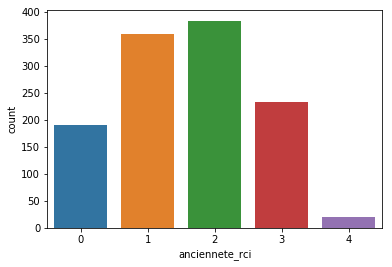

In [547]:
sns.countplot(x='anciennete_rci', data= raw_data);

**MT_ASSUR**

In [548]:
df.loc[df['MT_ASSUR'] ==0] #on ne dispose d'aucune ligne dont le montant d'assurance est nul
df = df.fillna(value={'MT_ASSUR':0})    #on peut imaginer remplacer les NaN par des zéros

**AGE_VEH**

On s'aperçoit que les valeurs manquantes correspondent aux véhicules neufs.

In [549]:
df[['AGE_VEH', 'VN_VO']]

,AGE_VEH,VN_VO
0,NaN,VN
1,28.0,VO
2,16.0,VO
3,10.0,VO
4,7.0,VO
5,NaN,VN
6,NaN,VN
7,NaN,VN
8,3.0,VO
9,71.0,VO


In [550]:
df = df.fillna(value={'AGE_VEH':0})

**VR_BALLON**

In [551]:
df = df.fillna(value={'VR_BALLON':0})

**MT_PREST**

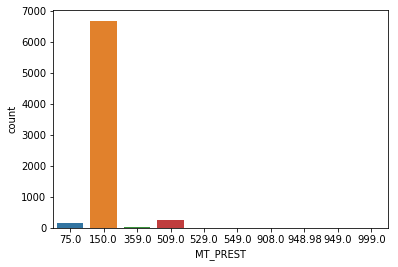

In [552]:
sns.countplot(x='MT_PREST', data= raw_data);

In [553]:
total = raw_data.groupby('MT_PREST').size()
percent = round(raw_data.groupby('MT_PREST').size()/len(raw_data),2) 
pd.concat([total, percent], axis=1, keys= ['Total', 'Percent'])

,Total,Percent
MT_PREST,,
75.00,166,0.02
150.00,6691,0.79
359.00,39,0.00
509.00,268,0.03
529.00,2,0.00
549.00,3,0.00
908.00,2,0.00
948.98,1,0.00
949.00,1,0.00


In [554]:
df = df.fillna(value={'MT_PREST':0})    

**MODE_LOGT**

In [555]:
#rappel : situation_fam  (1=Marié, 2=Célib, 3=Divorcé, 4=Veuf, 5=Séparé, 11=Colloc)
#MODE_LOGT Mode de logement C (4 mods) (1=locataire, 2=proprio, 3=autre, 4=chez les parents)
df_tmp = df.loc[df['MODE_LOGT'].isna()]
#sns.countplot(x='STITUATION_FAM', data=df_tmp);
df_tmp.groupby('STITUATION_FAM').size()

STITUATION_FAM
1     61
11     6
2     36
3      0
4      1
5      4
dtype: int64

61 Mariés, 
36 Célibs

In [556]:
ct = pd.crosstab(df['MODE_LOGT'], df['STITUATION_FAM'], normalize=True)
stat, p, dof, exp = stats.chi2_contingency(ct)
print('Stat = {0:.3f}, p = {1:.3f}, donc on rejette pas l hyp d indépendance '.format(stat, p))

Stat = 0.363, p = 1.000, donc on rejette pas l hyp d indépendance 


Catégories fortements rpz:
63% des inds sont mariés et proprios. Vient ensuite les célib/proprios, les célib/chez les parents, les mariés locataires. 

vs
Catégories très peu représentés :
Autre, 

=> 75% de chance d'être proprio.
Intéressant de regarder les profils colonnes

In [557]:
#round(ct.apply(lambda col : col / sum(col), axis=0),3)
#même chose qu'en dessous !
print('TABLEAU PROFILS COLONNES')
round(pd.crosstab(df['MODE_LOGT'], df['STITUATION_FAM'], normalize = 'columns', margins=True, dropna=True),3)

TABLEAU PROFILS COLONNES


STITUATION_FAM,1,11,2,3,4,5,All
MODE_LOGT,,,,,,,
1,0.102,0.353,0.212,0.223,0.026,0.305,0.137
2,0.883,0.538,0.379,0.702,0.967,0.627,0.764
3,0.004,0.058,0.013,0.008,0.000,0.017,0.008
4,0.011,0.052,0.397,0.066,0.007,0.051,0.091


#rappel : situation_fam  (1=Marié, 2=Célib, 3=Divorcé, 4=Veuf, 5=Séparé, 11=Colloc)
#MODE_LOGT Mode de logement C (4 mods) (1=locataire, 2=proprio, 3=autre, 4=chez les parents)

1 (61) : Parmi les gens mariés, 88% sont proprios
2 (36) : Parmi les gens célibataires, c'est plus compliqué.. 1,2 ou 4..
4 (1) : Parmi les veufs, 96% sont proprios 
5 (4) : Parmi les séparés, env 60% proprios, 30% loc
11 (6) : Parmi les colocs, env 55% sont proprios et 35% sont locataires

Il y 80% d'être proprio quand on est marié. On décide de remplacer les NA Mode Logt des mariés par proprio et on se débarrasse des autres lignes. 

In [558]:
len(df.loc[(df['MODE_LOGT'].isna()) & (df['def12_31']=='1'),])

10

In [559]:
df.loc[(df['MODE_LOGT'].isna()) & (df['STITUATION_FAM']=='1'),['MODE_LOGT']] = '2'

In [560]:
df.loc[(df['MODE_LOGT'].isna()) & (df['STITUATION_FAM']=='11'),['MODE_LOGT']] = '2'

In [561]:
df.loc[(df['MODE_LOGT'].isna()) & (df['STITUATION_FAM']=='4'),['MODE_LOGT']] = '2'

In [562]:
df.loc[(df['MODE_LOGT'].isna()) & (df['STITUATION_FAM']=='5'),['MODE_LOGT']] = '2'

 **VERIFICATION NA**

In [563]:
df.shape #vs (8457, 19), on a bien supprimé 36 obs

(8457, 18)

In [564]:
df.isnull().sum().sort_values(ascending=False)

anciennete_rci    7271
MODE_LOGT           36
def12_31             0
MT_APPORT            0
STITUATION_FAM       0
AGE_VEH              0
VN_VO                0
MARQUE               0
PRIX_VEH             0
MT_FINANCE           0
pc_appo              0
MT_MENS              0
VR_BALLON            0
DUREE_CONTRAT        0
MT_PREST             0
MT_ASSUR             0
age_cli              0
ANC_EMPLOI           0
dtype: int64

### Analyse des variables quantitatives 

On s'attend à rajouter à notre df 12 nouvelles variables (les vars quanti) (19 + 12 = 31)

In [565]:
num_feats = df.dtypes[(df.dtypes != 'category')].index
list(num_feats) #1

['ANC_EMPLOI',
 'AGE_VEH',
 'PRIX_VEH',
 'MT_APPORT',
 'MT_FINANCE',
 'MT_MENS',
 'VR_BALLON',
 'DUREE_CONTRAT',
 'MT_PREST',
 'MT_ASSUR',
 'age_cli',
 'pc_appo']

## Tableaux Profils Colonne <a id="part2"></a>

On dispose désormais de **17** variables qualitatives à étudier

In [566]:
#num_feats = df.dtypes[df.dtypes != 'category'].index
cat_feats = df.dtypes[df.dtypes == 'category'].index
cat_feats = cat_feats.drop('def12_31')
list(cat_feats)

['STITUATION_FAM', 'MODE_LOGT', 'VN_VO', 'MARQUE', 'anciennete_rci']

On créer 2 fonctions pour nous permettre d'afficher les deux tableaux profils / colonne

In [567]:
#Pour afficher deux tableaux en même temps
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [568]:
def comparer_cible(name):
    d1 = pd.crosstab(df.loc[df['def12_31']=='0', name], df.loc[df['def12_31']=='0','def12_31'])
    d2 = round(pd.crosstab(df.loc[df['def12_31']=='0', name], df.loc[df['def12_31']=='0','def12_31'], normalize='columns'),2)*100

    d3 = pd.crosstab(df.loc[df['def12_31']=='1', name], df.loc[df['def12_31']=='1','def12_31'])
    d4 = round(pd.crosstab(df.loc[df['def12_31']=='1', name], df.loc[df['def12_31']=='1','def12_31'], normalize='columns'),2)*100
    
    df_tmp1 = pd.concat([d1,d2], axis=1, keys=['Effectif', 'Pourcentage'])
    df_tmp2 = pd.concat([d3,d4], axis=1, keys=['Effectif', 'Pourcentage'])
    
    display_side_by_side(df_tmp1, df_tmp2)

def afficher_chi2(name, df):
    df_tmp = pd.crosstab(df[name], df['def12_31'])
    stat, p, df , exp = stats.chi2_contingency(df_tmp)
    #print('Test {0}, stat= {1:.0f}, p = {2}'.format(name, stat, p))
    return [stat, p]

In [569]:
def comparer_2dist(name_var,df,x=0):
    df0 = df.loc[df['def12_31']=='0', ]
    df1 = df.loc[df['def12_31']=='1', ]

    fig, ax = plt.subplots()
    sns.distplot(df0[name_var], hist=False, rug=True, color='b')
    sns.distplot(df1[name_var], hist=False,rug=True, color='r')
    ax.legend(('0', '1'), loc='upper right')
    ax.set_xlabel(name_var)
    ax.axvline(x);

In [570]:
l = []
for col in cat_feats:
    l.append(afficher_chi2(col, df))
df_tmp = pd.DataFrame(l, columns=['stat', 'p']).sort_values('stat', ascending=False)
for name, stat, p in zip(cat_feats, df_tmp['stat'], df_tmp['p']):
    print('Test {0}, stat= {1:.0f}, p = {2}'.format(name, stat, p))

Test STITUATION_FAM, stat= 115, p = 5.840388837515374e-12
Test MODE_LOGT, stat= 39, p = 3.327401288141921e-10
Test VN_VO, stat= 38, p = 3.528658695163948e-07
Test MARQUE, stat= 37, p = 4.530425322578564e-08
Test anciennete_rci, stat= 5, p = 0.322447710599715


**ANC_EMPLOI_CAT**

In [571]:
df['ANC_EMPLOI'] = df['ANC_EMPLOI']/12

In [572]:
df['ANC_EMPLOI_CAT'] = 0
df.loc[(df['ANC_EMPLOI']<=5), ['ANC_EMPLOI_CAT']] = '(0, 5]'
df.loc[(df['ANC_EMPLOI']>5) & (df['ANC_EMPLOI']<=10), ['ANC_EMPLOI_CAT']] = '(5, 10]'
df.loc[(df['ANC_EMPLOI']>10) & (df['ANC_EMPLOI']<=20), ['ANC_EMPLOI_CAT']] = '(10, 20]'
df.loc[(df['ANC_EMPLOI']>20), ['ANC_EMPLOI_CAT']] = '(20, .]'

In [573]:
comparer_cible('ANC_EMPLOI_CAT')

,Effectif,Pourcentage
def12_31,0,0
ANC_EMPLOI_CAT,,
"(0, 5]",1424,17.0
"(10, 20]",2920,35.0
"(20, .]",2051,25.0
"(5, 10]",1964,23.0
,Effectif,Pourcentage
def12_31,1,1
ANC_EMPLOI_CAT,,
"(0, 5]",29,30.0


La nouvelle répartition est bien plus intéressante. Le pourcentage de très jeunes employés est quasiment le double chez les personnes qui ont fait défaut. 
On observe une autre grosse différence sur l'intervalle des plus de 20 ans d'ancienneté (3x supérieur chez les non-défaut)


**AGE_VEH_CAT**

On a plusieurs classes qui sont très peu représentée dont il va falloir se débarrasser. 

count    8457.000000
mean        9.236963
std        18.138080
min         0.000000
25%         0.000000
50%         0.000000
75%         8.000000
max       101.000000
Name: AGE_VEH, dtype: float64

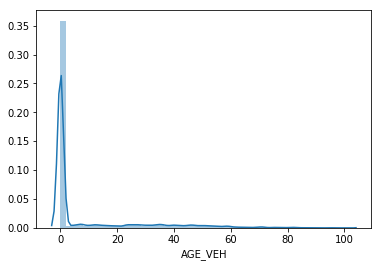

In [574]:
sns.distplot(df['AGE_VEH']);
df['AGE_VEH'].describe()

In [575]:
df['AGE_VEH_CAT'] = 0
df.loc[(df['AGE_VEH']==0), ['AGE_VEH_CAT']] = '0'
df.loc[(df['AGE_VEH']>0) & (df['AGE_VEH']<=40), ['AGE_VEH_CAT']] = '(0,40]'
df.loc[(df['AGE_VEH']>40), ['AGE_VEH_CAT']] = '(40,.]'

In [576]:
comparer_cible('AGE_VEH_CAT')

,Effectif,Pourcentage
def12_31,0,0
AGE_VEH_CAT,,
"(0,40]",1610,19.0
"(40,.]",787,9.0
0,5962,71.0
,Effectif,Pourcentage
def12_31,1,1
AGE_VEH_CAT,,
"(0,40]",28,29.0
"(40,.]",29,30.0


Ce découpage de la variable AGE_VEH_CAT2 est plus intéressant. On a bien 3 classes bien représentées

**PRIX_VEH_CAT**

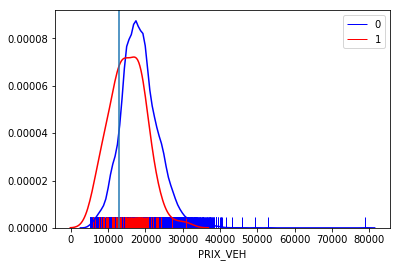

In [577]:
comparer_2dist('PRIX_VEH', df, 13000)

In [578]:
df['PRIX_VEH_CAT'] = 0
df.loc[(df['PRIX_VEH']<=13000), ['PRIX_VEH_CAT']] = '(0,13000]'
df.loc[(df['PRIX_VEH']>13000), ['PRIX_VEH_CAT']] = '(13000,.]'

In [579]:
comparer_cible('PRIX_VEH_CAT')

,Effectif,Pourcentage
def12_31,0,0
PRIX_VEH_CAT,,
"(0,13000]",1006,12.0
"(13000,.]",7353,88.0
,Effectif,Pourcentage
def12_31,1,1
PRIX_VEH_CAT,,
"(0,13000]",34,35.0
"(13000,.]",64,65.0


**MT_APPORT_CAT**

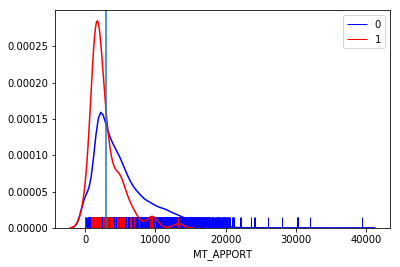

In [580]:
comparer_2dist('MT_APPORT', df, 3000)

In [581]:
df['MT_APPORT_CAT'] = 0
df.loc[(df['MT_APPORT']<=3000), ['MT_APPORT_CAT']] = '(0,3000]'
df.loc[(df['MT_APPORT']>3000), ['MT_APPORT_CAT']] = '(3000,.]'

In [582]:
comparer_cible('MT_APPORT_CAT')

,Effectif,Pourcentage
def12_31,0,0
MT_APPORT_CAT,,
"(0,3000]",3278,39.0
"(3000,.]",5081,61.0
,Effectif,Pourcentage
def12_31,1,1
MT_APPORT_CAT,,
"(0,3000]",66,67.0
"(3000,.]",32,33.0


**pc_apport_CAT**

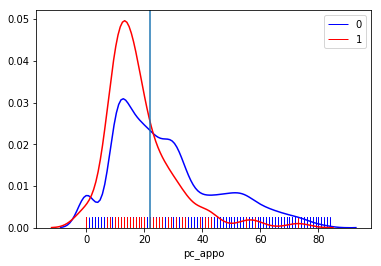

In [583]:
comparer_2dist('pc_appo', df, 22)

In [584]:
df['pc_appo_CAT'] = 0
df.loc[df['pc_appo']<=22, ['pc_appo_CAT']] = '(0, 22]'
df.loc[(df['pc_appo']>22), ['pc_appo_CAT']] = '(22, .]'

In [585]:
comparer_cible('pc_appo_CAT')

,Effectif,Pourcentage
def12_31,0,0
pc_appo_CAT,,
"(0, 22]",4059,49.0
"(22, .]",4300,51.0
,Effectif,Pourcentage
def12_31,1,1
pc_appo_CAT,,
"(0, 22]",73,74.0
"(22, .]",25,26.0


**MT_FINANCE_CAT**

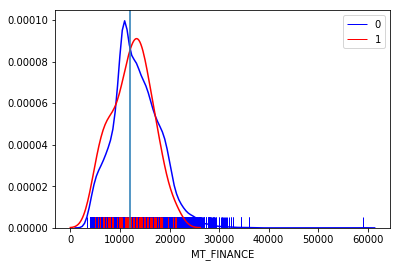

In [586]:
comparer_2dist('MT_FINANCE', df, 12000); #9000 & 

In [587]:
df['MT_FINANCE_CAT']=0
df.loc[(df['MT_FINANCE']<=9000), ['MT_FINANCE_CAT']] = '(0,9000]'
df.loc[(df['MT_FINANCE']>9000) & (df['MT_FINANCE']<=12000), ['MT_FINANCE_CAT']] = '(9000,12000]'
df.loc[(df['MT_FINANCE']>12000), ['MT_FINANCE_CAT']] = '(12000,.]'

In [588]:
comparer_cible('MT_FINANCE_CAT')

,Effectif,Pourcentage
def12_31,0,0
MT_FINANCE_CAT,,
"(0,9000]",1422,17.0
"(12000,.]",4734,57.0
"(9000,12000]",2203,26.0
,Effectif,Pourcentage
def12_31,1,1
MT_FINANCE_CAT,,
"(0,9000]",23,23.0
"(12000,.]",52,53.0


On remarque qu'en dépit de notre manière de découper la variable les deux distributions sont très peu séparable ! Cela concorde avec le test du Chi2 d'indépendance. 

**VR_BALLON_CAT**

In [589]:
comparer_cible('VR_BALLON')

,Effectif,Pourcentage
def12_31,0,0
VR_BALLON,,
0.00,5163,62.0
277.60,1,0.0
399.14,1,0.0
3000.09,1,0.0
3496.81,1,0.0
3496.91,1,0.0
3577.59,1,0.0
3795.95,1,0.0


In [590]:
df['VR_BALLON_CAT'] = 0
df.loc[(df['VR_BALLON']==0), ['VR_BALLON_CAT']] = '0'
df.loc[(df['VR_BALLON']>0), ['VR_BALLON_CAT']] = '>0'

In [591]:
comparer_cible('VR_BALLON_CAT')

,Effectif,Pourcentage
def12_31,0,0
VR_BALLON_CAT,,
0,5163,62.0
>0,3196,38.0
,Effectif,Pourcentage
def12_31,1,1
VR_BALLON_CAT,,
0,75,77.0
>0,23,23.0


**DUREE_CONTRAT_CAT**

In [592]:
#sns.distplot(df['DUREE_CONTRAT']);
df.groupby('DUREE_CONTRAT').size()

DUREE_CONTRAT
5       10
6      417
12      28
18       6
24     218
27       3
30      25
34       2
36    4430
39       1
42      17
48     725
54      17
60    2558
dtype: int64

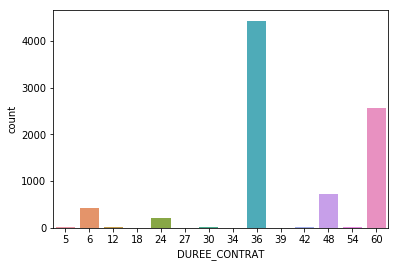

In [593]:
sns.countplot(df['DUREE_CONTRAT']);

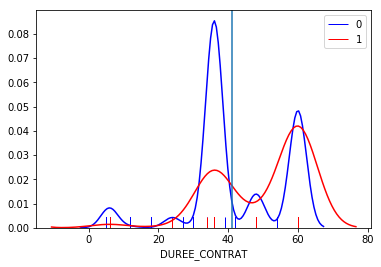

In [594]:
comparer_2dist('DUREE_CONTRAT', df, 41)

In [595]:
df['DUREE_CONTRAT_CAT'] = 0
df.loc[(df['DUREE_CONTRAT']<=30), ['DUREE_CONTRAT_CAT']] = '(0,30]'
df.loc[(df['DUREE_CONTRAT']>30) & (df['DUREE_CONTRAT']<=40), ['DUREE_CONTRAT_CAT']] = '(30, 40]'
df.loc[(df['DUREE_CONTRAT']>40), ['DUREE_CONTRAT_CAT']] = '(40,.]'

In [596]:
comparer_cible('DUREE_CONTRAT_CAT')

,Effectif,Pourcentage
def12_31,0,0
DUREE_CONTRAT_CAT,,
"(0,30]",704,8.0
"(30, 40]",4401,53.0
"(40,.]",3254,39.0
,Effectif,Pourcentage
def12_31,1,1
DUREE_CONTRAT_CAT,,
"(0,30]",3,3.0
"(30, 40]",32,33.0


**MT_PREST_CAT**

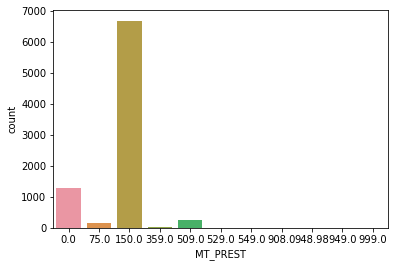

In [597]:
sns.countplot(df['MT_PREST']);

In [598]:
df.loc[df['def12_31']=='1',].groupby('MT_PREST').size()

MT_PREST
0.0       2
75.0      1
150.0    92
509.0     3
dtype: int64

In [599]:
df.loc[df['def12_31']=='0',].groupby('MT_PREST').size()

MT_PREST
0.00      1278
75.00      165
150.00    6599
359.00      39
509.00     265
529.00       2
549.00       3
908.00       2
948.98       1
949.00       1
999.00       4
dtype: int64

In [600]:
df['MT_PREST_CAT'] = 0
df.loc[(df['MT_PREST']==150), ['MT_PREST_CAT']] = '150'
df.loc[(df['MT_PREST']!=150), ['MT_PREST_CAT']] = 'autre'

In [601]:
comparer_cible('MT_PREST_CAT')

,Effectif,Pourcentage
def12_31,0,0
MT_PREST_CAT,,
150,6599,79.0
autre,1760,21.0
,Effectif,Pourcentage
def12_31,1,1
MT_PREST_CAT,,
150,92,94.0
autre,6,6.0


**MT_ASSUR**

In [602]:
df['MT_ASSUR_CAT'] = 0
df.loc[(df['MT_ASSUR']==0), ['MT_ASSUR_CAT']] = '0'
df.loc[(df['MT_ASSUR']>0), ['MT_ASSUR_CAT']] = '>0'

In [603]:
comparer_cible('MT_ASSUR_CAT')

,Effectif,Pourcentage
def12_31,0,0
MT_ASSUR_CAT,,
0,6680,80.0
>0,1679,20.0
,Effectif,Pourcentage
def12_31,1,1
MT_ASSUR_CAT,,
0,75,77.0
>0,23,23.0


Vraiment pas terrible cette variable pour discriminer les 2 types.

**age_cli_cat**

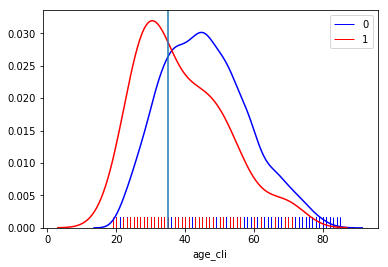

In [604]:
comparer_2dist('age_cli',df,35)

In [605]:
df['age_cli_CAT'] = pd.cut(df['age_cli'], precision=0, bins= 3)

In [606]:
comparer_cible('age_cli_CAT')

,Effectif,Pourcentage
def12_31,0,0
age_cli_CAT,,
"(19.0, 41.0]",3301,39.0
"(41.0, 63.0]",4268,51.0
"(63.0, 85.0]",790,9.0
,Effectif,Pourcentage
def12_31,1,1
age_cli_CAT,,
"(19.0, 41.0]",61,62.0
"(41.0, 63.0]",32,33.0


**MT_MENS**

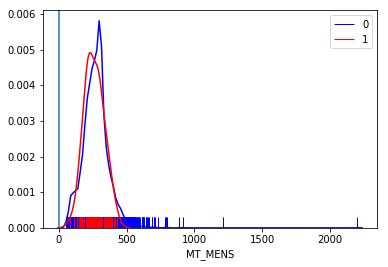

In [607]:
comparer_2dist('MT_MENS',df,0)

In [608]:
df['MT_MENS_CAT'] = 250
df.loc[(df['MT_MENS']<250), ['MT_MENS_CAT']] = '(0,250]'
df.loc[(df['MT_MENS']>=250), ['MT_MENS_CAT']] = '(250,.]'

In [609]:
comparer_cible('MT_MENS_CAT')

,Effectif,Pourcentage
def12_31,0,0
MT_MENS_CAT,,
"(0,250]",3246,39.0
"(250,.]",5113,61.0
,Effectif,Pourcentage
def12_31,1,1
MT_MENS_CAT,,
"(0,250]",46,47.0
"(250,.]",52,53.0


## Etude variables qualitatives <a id="part3"></a>

**STITUATION_FAM**

In [610]:
comparer_cible('STITUATION_FAM')

,Effectif,Pourcentage
def12_31,0,0
STITUATION_FAM,,
1,5966,71.0
11,329,4.0
2,1671,20.0
3,121,1.0
4,151,2.0
5,121,1.0
,Effectif,Pourcentage
def12_31,1,1


On en déduit que les mariées ne font pas défaut en générale d'apres ce tableau, car on a observé que une grosse proportions de 71% chez les mariées pour les gens qui ne font pas de défaut, ce qui est bcp superieur que 47% de gens qui ont fait défaut qui sont des mariées.

Par contre c'est le cas contraire chez les célibataires, 44% des gens qui ont fait défaut sont des célibataire, c'est plus la double des gens qui ne font pas défaut chez les célibataires. Donc on conclut que des célibataires ont une grosse chance de faire défaut. 

***Il existe toutefois des classes qui ont moins de 5 obs. qu'il va falloir merger..***

In [611]:
df['STITUATION_FAM_CAT'] = 0
df.loc[df['STITUATION_FAM'].isin(['11', '4','5']), ['STITUATION_FAM_CAT']] = 'autre'
df.loc[df['STITUATION_FAM'] == '1', ['STITUATION_FAM_CAT']] = 'marie'
df.loc[df['STITUATION_FAM'] == '2', ['STITUATION_FAM_CAT']] = 'celibataire'

In [612]:
df['STITUATION_FAM'] = df['STITUATION_FAM_CAT']
df = df.drop(['STITUATION_FAM_CAT'], axis=1)
comparer_cible('STITUATION_FAM')

,Effectif,Pourcentage
def12_31,0,0
STITUATION_FAM,,
0,121,1.0
autre,601,7.0
celibataire,1671,20.0
marie,5966,71.0
,Effectif,Pourcentage
def12_31,1,1
STITUATION_FAM,,
autre,9,9.0


**MODE_LOGT**

In [613]:
comparer_cible('MODE_LOGT')

,Effectif,Pourcentage
def12_31,0,0
MODE_LOGT,,
1,1124,13.0
2,6398,77.0
3,65,1.0
4,739,9.0
,Effectif,Pourcentage
def12_31,1,1
MODE_LOGT,,
1,23,24.0


On remarque que 77% de gens qui n'ont pas fait défaut sont des proprios, ceux qui sont bcp plus que des proprios qui ont fait défaut (52% parmi des gens qui ont fait défaut), donc on en déduit que des proprios ne font pas défaut en générale.

C'est le cas contraire pour les gens qui sont habitent chez les parents, 23% de gens qui font fait défaut sont ces gens la, c'est bcp plus que des "chez les parents" qui n'ont pas fait défaut (9% parmi des gens qui n'ont pas fait défaut) en proportion. Donc on en déduit que des "chez les parents" ont une forte de chance de faire défaut.

**VN_VO**

In [614]:
comparer_cible('VN_VO')

,Effectif,Pourcentage
def12_31,0,0
VN_VO,,
VN,5962,71.0
VO,2397,29.0
,Effectif,Pourcentage
def12_31,1,1
VN_VO,,
VN,41,42.0
VO,57,58.0


On remarque que 71% de gens qui n'ont pas fait défaut sont des gens qui ont une véhicule neuf, qui est supérieure que 43% des gens qui ont fait défaut alors qu'ils ont une véhicule neuf. Et on remarque aussi que 57% des gens qui ont faut défaut sont des gens qui ont une véhicule occasion, qui est preque la double des gens qui ont une véhicules neuf et n'ont pas fait défaut en proportion.

On conclut alors que des gens avec une véhicule neuf ne font pas défaut en générale, par contre les gens avec une voiture occasion ont une propa plus fort de faire défaut que ne pas faire défaut.

**MARQUE**

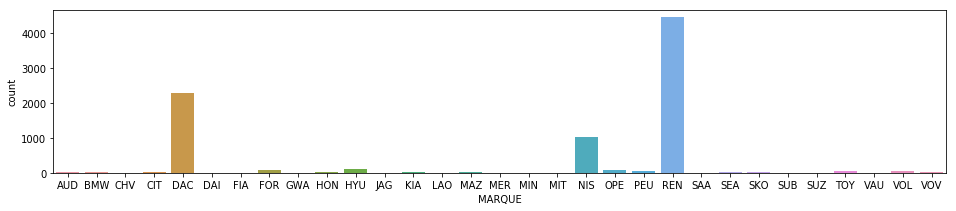

In [615]:
plt.figure(figsize=(16,3))
sns.countplot(df['MARQUE']);

In [616]:
df['MARQUE_CAT'] =0
df.loc[df['MARQUE'].isin(['REN', 'NIS', 'DAC']),['MARQUE_CAT']] = 'groupe_renault'
df.loc[-df['MARQUE'].isin(['REN', 'NIS', 'DAC']),['MARQUE_CAT']] = 'autre'
df['MARQUE'] = df['MARQUE_CAT']
df = df.drop(['MARQUE_CAT'], axis=1)

In [617]:
comparer_cible('MARQUE')

,Effectif,Pourcentage
def12_31,0,0
MARQUE,,
autre,641,8.0
groupe_renault,7718,92.0
,Effectif,Pourcentage
def12_31,1,1
MARQUE,,
autre,19,19.0
groupe_renault,79,81.0


## Feature Engineering <a id="part4"></a>


On créer 6 nouvelles features ! 

In [618]:
raw_data.head()

,ANC_EMPLOI,STITUATION_FAM,MODE_LOGT,AGE_VEH,VN_VO,MARQUE,PRIX_VEH,MT_APPORT,MT_FINANCE,MT_MENS,VR_BALLON,DUREE_CONTRAT,MT_PREST,MT_ASSUR,mois_gestion,age_cli,anciennete_rci,pc_appo,def12_31
0,65,2,1,NaN,VN,REN,19584.65,0.0,19584.65,95.01,19584.63,6,NaN,NaN,2015-01-03,28,1,0,0
1,563,11,2,28.0,VO,REN,16995.00,2123.0,14872.00,312.34,NaN,60,150.0,NaN,2014-01-06,64,3,12,0
2,107,2,2,16.0,VO,REN,19950.00,3869.0,16081.00,329.93,NaN,60,150.0,NaN,2015-01-08,51,3,19,0
3,143,2,2,10.0,VO,REN,17500.00,7143.5,10356.50,217.51,NaN,60,150.0,NaN,2015-01-04,42,4,41,0
4,110,2,NaN,7.0,VO,REN,19740.00,3789.4,15950.60,310.33,7523.04,36,150.0,395.0,2015-01-02,34,4,19,0


In [619]:
#PRIX_TOTAL
df = df.assign(PRIX_TOTAL = df['PRIX_VEH']+df['MT_APPORT']+df['MT_PREST'] + df['VR_BALLON']+df['MT_ASSUR'])

In [620]:
#MENS_par_FINANCE
df = df.assign(MENS_par_FINANCE= df['MT_MENS']/df['MT_FINANCE'])

In [621]:
#PREST_par_FINANCE
df = df.assign(PREST_par_FINANCE= df['MT_PREST']/df['MT_FINANCE'])

In [622]:
#ASSUR_par_FINANCE
df = df.assign(ASSUR_par_FINANCE= df['MT_ASSUR']/df['MT_FINANCE'])

In [623]:
#age_cli_par_DUREE
df = df.assign(age_cli_par_DUREE= df['age_cli']/df['DUREE_CONTRAT'])

In [624]:
#DUREE_C_par_FINANCE
df = df.assign(DUREE_C_par_FINANCE= df['DUREE_CONTRAT']/df['MT_FINANCE'])

In [625]:
cols = ['PRIX_TOTAL', 'MENS_par_FINANCE', 'DUREE_C_par_FINANCE', \
'PREST_par_FINANCE', 'ASSUR_par_FINANCE', 'age_cli_par_DUREE']
for col in cols:
    df[col+'_CAT'] = pd.qcut(df[col], q= 2, precision=0, duplicates='drop')

In [626]:
for col in cols:
    col = col + '_CAT'
    df[col] = df[col].astype('category',copy=False)
    comparer_cible(col)

,Effectif,Pourcentage
def12_31,0,0
PRIX_TOTAL_CAT,,
"(5039.0, 26467.0]",4154,50.0
"(26467.0, 99150.0]",4205,50.0
,Effectif,Pourcentage
def12_31,1,1
PRIX_TOTAL_CAT,,
"(5039.0, 26467.0]",75,77.0
"(26467.0, 99150.0]",23,23.0


,Effectif,Pourcentage
def12_31,0,0
MENS_par_FINANCE_CAT,,
"(-0.095, 0.02]",4221,50.0
"(0.02, 0.2]",4138,50.0
,Effectif,Pourcentage
def12_31,1,1
MENS_par_FINANCE_CAT,,
"(-0.095, 0.02]",41,42.0
"(0.02, 0.2]",57,58.0


,Effectif,Pourcentage
def12_31,0,0
DUREE_C_par_FINANCE_CAT,,
"(-0.0998, 0.003]",4201,50.0
"(0.003, 0.02]",4158,50.0
,Effectif,Pourcentage
def12_31,1,1
DUREE_C_par_FINANCE_CAT,,
"(-0.0998, 0.003]",28,29.0
"(0.003, 0.02]",70,71.0


,Effectif,Pourcentage
def12_31,0,0
PREST_par_FINANCE_CAT,,
"(-0.1, 0.01]",4197,50.0
"(0.01, 0.2]",4162,50.0
,Effectif,Pourcentage
def12_31,1,1
PREST_par_FINANCE_CAT,,
"(-0.1, 0.01]",32,33.0
"(0.01, 0.2]",66,67.0


,Effectif,Pourcentage
def12_31,0,0
ASSUR_par_FINANCE_CAT,,
"(-0.1, 0.2]",8359,100.0
,Effectif,Pourcentage
def12_31,1,1
ASSUR_par_FINANCE_CAT,,
"(-0.1, 0.2]",98,100.0


,Effectif,Pourcentage
def12_31,0,0
age_cli_par_DUREE_CAT,,
"(-1.0, 1.0]",4173,50.0
"(1.0, 14.0]",4186,50.0
,Effectif,Pourcentage
def12_31,1,1
age_cli_par_DUREE_CAT,,
"(-1.0, 1.0]",74,76.0
"(1.0, 14.0]",24,24.0


In [627]:
df = df.drop(cols, axis=1)
df.shape


(8457, 36)

## Bilan audit et création dummies <a id="part5"></a>

On se débarrasse des variables suivantes : 
- anciennete_rci

Pour les variables qualitatives, on a juste transformé Situation familiale

In [628]:
df.shape #(8421, 36)

(8457, 36)

In [629]:
df_tmp = df.loc[:,['ANC_EMPLOI', 'AGE_VEH', 'PRIX_VEH', 'MT_APPORT', 'MT_FINANCE','MT_MENS', \
'VR_BALLON', 'DUREE_CONTRAT', 'MT_PREST', 'MT_ASSUR', 'age_cli', 'pc_appo']]
df = df.drop(['ANC_EMPLOI', 'AGE_VEH', 'PRIX_VEH', 'MT_APPORT', 'MT_FINANCE','MT_MENS', \
'VR_BALLON', 'DUREE_CONTRAT', 'MT_PREST', 'MT_ASSUR', 'age_cli', 'pc_appo'], axis=1)

In [630]:
df.shape #18 + 6 = 24

(8457, 24)

In [631]:
df.dtypes[df.dtypes!='categoy'].index
#on enlève 'mois_gestion'
tmp = ['STITUATION_FAM', 'MARQUE', 'ANC_EMPLOI_CAT', \
'AGE_VEH_CAT', 'PRIX_VEH_CAT', 'MT_APPORT_CAT', 'pc_appo_CAT', \
'MT_FINANCE_CAT', 'VR_BALLON_CAT', 'DUREE_CONTRAT_CAT', 'MT_PREST_CAT', \
'MT_ASSUR_CAT', 'MT_MENS_CAT']

for col in tmp:
    df[col] = df[col].astype('category',copy=False)
    
#dtypes: category(18), datetime64[ns](1)

In [632]:
non_dummy_col = ['def12_31']
dummy_col = list(set(df.columns) - set(non_dummy_col))
df = pd.get_dummies(df, columns = dummy_col)

In [633]:
df.shape

(8457, 59)

In [636]:
df = pd.concat([df, df_tmp], axis = 1)
df.shape


(8457, 71)

# Etape 2 <a id="etap2"></a>

Dimensions du jeu données : 

**8457 rows × 60 columns**

## Resampling with Bootstrap

In [93]:
df_boot = resample(df, replace = True, n_samples = 6000)
#print('Bootstrap Sample: %s' % boot)
df_boot.head()

,def12_31,"DUREE_C_par_FINANCE_CAT_(-0.0998, 0.003]","DUREE_C_par_FINANCE_CAT_(0.003, 0.02]",MT_PREST_CAT_150,MT_PREST_CAT_autre,pc_appo_0,pc_appo_1,pc_appo_2,pc_appo_3,pc_appo_4,...,ANC_EMPLOI_60.916666666666664,ANC_EMPLOI_61.25,ANC_EMPLOI_62.166666666666664,ANC_EMPLOI_62.25,ANC_EMPLOI_62.833333333333336,ANC_EMPLOI_62.916666666666664,ANC_EMPLOI_66.83333333333333,ANC_EMPLOI_66.91666666666667,ANC_EMPLOI_69.25,ANC_EMPLOI_81.16666666666667
7705,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6953,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6853,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5503,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1535,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Resampling with SMOTE

In [639]:
X = np.array(df.loc[:, df.columns != 'def12_31'])
y = np.array(df.loc[:, df.columns == 'def12_31'])
print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))

Shape of X: (8457, 70)
Shape of y: (8457, 1)


In [640]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (5919, 70)
Number transactions y_train dataset:  (5919, 1)
Number transactions X_test dataset:  (2538, 70)
Number transactions y_test dataset:  (2538, 1)


In [641]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train=='1')))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train=='0')))


Before OverSampling, counts of label '1': [68]
Before OverSampling, counts of label '0': [5851] 



In [642]:
sm = SMOTE(random_state = 2, sampling_strategy = 'minority')
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res=='1')))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res=='0')))

After OverSampling, the shape of train_X: (11702, 70)
After OverSampling, the shape of train_y: (11702,) 

After OverSampling, counts of label '1': 5851
After OverSampling, counts of label '0': 5851


### Test de performance avec la regression logistique

In [643]:
lr = LogisticRegression()

lr.fit(X_train_res, y_train_res)

D:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [644]:
lr_pred = lr.predict(X_test)
lr_pred

array(['0', '1', '1', ..., '0', '0', '0'], dtype=object)

In [645]:
accuracy_score(y_test, lr_pred)

0.7072498029944838

In [646]:
recall_score(y_test, lr_pred, pos_label = '1')

0.7333333333333333

In [647]:
f1_score(y_test, lr_pred, pos_label = '1')

0.05590851334180432

In [648]:
precision_score(y_test, lr_pred, pos_label = '1')

0.02906208718626156

**avec penalite l1**

In [661]:
y_train_res = y_train_res.astype('int32')

In [662]:
param = {
    'penalty': ('none', 'l1', 'l2', 'elasticnet'),
    'C': np.linspace(1, 10, 10),
    'solver': ('liblinear', 'saga')
}
    
clf = GridSearchCV(LogisticRegression(class_weight = 'balanced'),
                   param,
                   cv = 5,
                   verbose = 5,
                   scoring = ('precision', 'recall', 'f1'),
                   refit = 'f1',
                   n_jobs = -1
                  )
clf.fit(X_train_res, y_train_res)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  6.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                         'penalty': ('none', 'l1', 'l2', 'elasticnet'),
                         'solver': ('liblinear', 'saga')},
             pre_dispatch='2*n_jobs', refit='f1', return_train_score=False,
             scoring=('precision', 'recall', 'f1'), 

In [663]:
clf.best_params_

{'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

In [664]:
res = pd.DataFrame(clf.cv_results_)
res.sort_values(by = 'rank_test_f1')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_precision,split1_test_precision,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
2,7.524017,1.004587,0.008796,0.001325,1,l1,liblinear,"{'C': 1.0, 'penalty': 'l1', 'solver': 'libline...",0.773026,0.750000,...,0.010912,1,0.787930,0.790303,0.790053,0.778776,0.795351,0.788482,0.005431,1
34,14.442559,1.698200,0.012803,0.001930,5,l1,liblinear,"{'C': 5.0, 'penalty': 'l1', 'solver': 'libline...",0.775124,0.751156,...,0.009996,4,0.789430,0.789793,0.789560,0.777778,0.795851,0.788482,0.005876,2
42,15.319862,1.981719,0.012393,0.001200,6,l1,liblinear,"{'C': 6.0, 'penalty': 'l1', 'solver': 'libline...",0.775124,0.751156,...,0.009996,4,0.789430,0.789793,0.789560,0.777778,0.795851,0.788482,0.005876,2
26,15.225994,1.918953,0.016192,0.003486,4,l1,liblinear,"{'C': 4.0, 'penalty': 'l1', 'solver': 'libline...",0.775124,0.751735,...,0.010242,2,0.789430,0.790113,0.789731,0.777278,0.795851,0.788481,0.006082,4
18,14.456759,2.098003,0.013096,0.003637,3,l1,liblinear,"{'C': 3.0, 'penalty': 'l1', 'solver': 'libline...",0.775124,0.750577,...,0.010141,2,0.789430,0.789474,0.790053,0.778096,0.795351,0.788481,0.005646,5
58,15.386219,2.502421,0.018191,0.010042,8,l1,liblinear,"{'C': 8.0, 'penalty': 'l1', 'solver': 'libline...",0.775124,0.750577,...,0.009996,4,0.789430,0.789474,0.789560,0.777778,0.795851,0.788418,0.005863,6
66,14.617021,0.973907,0.017392,0.007333,9,l1,liblinear,"{'C': 9.0, 'penalty': 'l1', 'solver': 'libline...",0.775124,0.750577,...,0.009996,4,0.789430,0.789474,0.789238,0.778096,0.795851,0.788417,0.005738,7
50,14.788961,1.360425,0.015792,0.002784,7,l1,liblinear,"{'C': 7.0, 'penalty': 'l1', 'solver': 'libline...",0.775124,0.750964,...,0.009776,9,0.789430,0.789303,0.789560,0.777778,0.795851,0.788384,0.005858,8
74,13.897350,1.196371,0.014593,0.003772,10,l1,liblinear,"{'C': 10.0, 'penalty': 'l1', 'solver': 'liblin...",0.775124,0.750385,...,0.009776,9,0.789430,0.788983,0.789560,0.778096,0.795851,0.788384,0.005735,9
10,18.065891,1.998808,0.018190,0.012426,2,l1,liblinear,"{'C': 2.0, 'penalty': 'l1', 'solver': 'libline...",0.774486,0.751347,...,0.010469,8,0.789099,0.790283,0.790053,0.777278,0.795021,0.788347,0.005904,10


In [665]:
feats = ['param_C', 'param_penalty', 'param_solver','mean_test_precision', \
'mean_test_recall','mean_test_f1', 'rank_test_f1']
res[feats].sort_values('rank_test_f1')


,param_C,param_penalty,param_solver,mean_test_precision,mean_test_recall,mean_test_f1,rank_test_f1
2,1,l1,liblinear,0.759361,0.820199,0.788482,1
34,5,l1,liblinear,0.759930,0.819516,0.788482,2
42,6,l1,liblinear,0.759930,0.819516,0.788482,2
26,4,l1,liblinear,0.759926,0.819516,0.788481,4
18,3,l1,liblinear,0.759933,0.819516,0.788481,5
58,8,l1,liblinear,0.759814,0.819516,0.788418,6
66,9,l1,liblinear,0.759813,0.819516,0.788417,7
50,7,l1,liblinear,0.759892,0.819345,0.788384,8
74,10,l1,liblinear,0.759893,0.819345,0.788384,9
10,2,l1,liblinear,0.759678,0.819516,0.788347,10


In [649]:
lr1 = LogisticRegression(C=3, penalty='l1', verbose = 5, solver = 'liblinear')
lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=5,
                   warm_start=False)

In [650]:
lr1_pred = lr1.predict(X_test)
lr1_pred

array(['0', '1', '1', ..., '0', '0', '0'], dtype=object)

In [651]:
accuracy_score(y_test, lr1_pred)

0.735618597320725

In [652]:
precision_score(y_test, lr1_pred, pos_label = '1')

0.032116788321167884

In [653]:
recall_score(y_test, lr1_pred, pos_label = '1')

0.7333333333333333

In [654]:
f1_score(y_test, lr1_pred, pos_label = '1')

0.061538461538461535

**Matrice de confusion**

In [655]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the train dataset: 76.47058823529412%


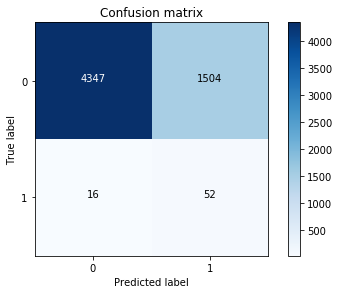

In [656]:
y_train_pre = lr1.predict(X_train)

cnf_matrix_tra = confusion_matrix(y_train, y_train_pre)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

Recall metric in the testing dataset: 73.33333333333333%


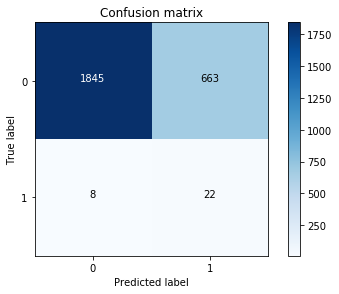

In [657]:
y_pre = lr1.predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pre)

print("Recall metric in the testing dataset: {}%".format(100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])))
#print("Precision metric in the testing dataset: {}%".format(100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])))
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.show()

In [658]:
tmp = lr1.fit(X_train_res, y_train_res.ravel())

[LibLinear]

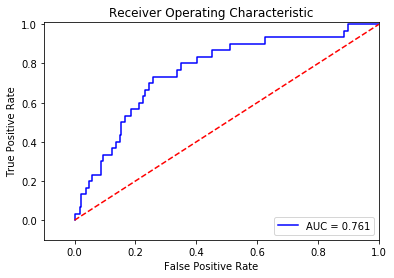

In [659]:
y_pred_sample_score = tmp.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred_sample_score, pos_label = '1')

roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

D:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


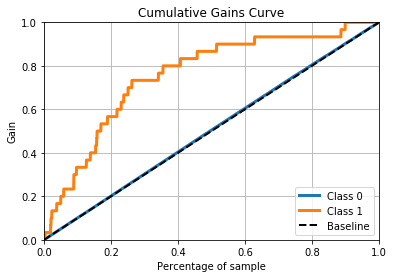

In [660]:
predicted_proba = lr1.predict_proba(X_test)
plot_cumulative_gain(y_test, predicted_proba)

## Resampling with ADASYN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [ ]:
ada = ADASYN(random_state = 2)
X_resamp_tr, y_resamp_tr = ada.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_resamp_tr.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_resamp_tr.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_resamp_tr=='1')))
print("After OverSampling, counts of label '0': {}".format(sum(y_resamp_tr=='0')))

In [ ]:
lr1_ada = LogisticRegression(C=3, penalty='l1', verbose = 5, solver = 'liblinear')
lr1_ada.fit(X_resamp_tr, y_resamp_tr.ravel())

In [ ]:
lr1_ada_pred = lr1_ada.predict(X_test)
print("Accuracy:",accuracy_score(y_test, lr1_ada_pred))
print("Precision:",precision_score(y_test, lr1_ada_pred,pos_label = '1'))

In [ ]:
cnf_matrix_tra = confusion_matrix(y_test, lr1_ada_pred)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [ ]:
predicted_proba = lr1_ada.predict_proba(X_test)
plot_cumulative_gain(y_test, predicted_proba)

### Test de performance avec la Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)
rfc_model = RandomForestClassifier(random_state=0)
rfc_model.fit(X_train, y_train.ravel())

In [ ]:
y_pred_rfc = rfc_model.predict(X_test)


In [ ]:
print("Accuracy:",accuracy_score(y_test, y_pred_rfc))
print("precision:",precision_score(y_test, y_pred_rfc, pos_label = '1'))

In [ ]:
cnf_matrix_tra = confusion_matrix(y_test, y_pred_rfc)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [ ]:
predicted_proba = rfc_model.predict_proba(X_test)
plot_cumulative_gain(y_test, predicted_proba)

In [ ]:
rfc_model2 = RandomForestClassifier(random_state=0)
rfc_model2.fit(X_train_res, y_train_res.ravel())

In [ ]:
y_pred_rfc2 = rfc_model2.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred_rfc2))
print("precision:",precision_score(y_test, y_pred_rfc, pos_label = '1'))

In [ ]:
cnf_matrix_tra = confusion_matrix(y_test, y_pred_rfc2)

print("Recall metric in the train dataset: {}%".format(100*cnf_matrix_tra[1,1]/(cnf_matrix_tra[1,0]+cnf_matrix_tra[1,1])))


class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix_tra , classes=class_names, title='Confusion matrix')
plt.show()

In [ ]:
predicted_proba = rfc_model2.predict_proba(X_test)
plot_cumulative_gain(y_test, predicted_proba)